I use SVM to build and train a model using human cell records, and classify cells to whether the samples are benign (mild state) or malignant (evil state).

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable (This gets done by kernel function of SVM classifier). A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane.

# Table of Contents

1. **_Necessary imports_**
2. **_About the Cancer data_**
* **_Load data from CSV file_**
* **_Distribution of the classes_**
* **_Data pre-processing and selection_**
* **_Divide the data as Train/Test dataset_**
* **_Modeling (SVM with Scikit-learn)_**
* **_Evaluation (Results)_**

# 1. _Necessary imports_

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report

# 2. _About the Cancer data_

The example is based on a dataset that is publicly available from the UCI Machine Learning Repository [Asuncion and Newman, 2007](http://mlearn.ics.uci.edu/MLRepository.html).  

Public source: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Identifier|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

In this example, I'm using a dataset that has a 10 predictors (columns) in each record, and 700 records (rows).

# 3. _Load data from CSV file_

In [7]:
cell_df = pd.read_csv('data\cell_samples.csv')

The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

In [8]:
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


# 4. _Distribution of the classes_

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

<AxesSubplot:xlabel='Clump', ylabel='UnifSize'>

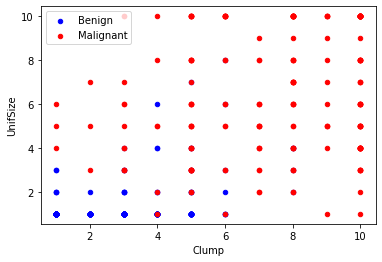

In [12]:
benign_df = cell_df[cell_df['Class']==2][0:200]
malignant_df = cell_df[cell_df['Class']==4][0:200]

axes = benign_df.plot(kind='scatter', x='Clump', y='UnifSize', color='blue', label='Benign')
malignant_df.plot(kind='scatter', x='Clump', y='UnifSize', color='red', label='Malignant', ax = axes)

# 5. _Data pre-processing and selection_

Lets first look at columns data types:

In [13]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the **BareNuc** column includes some values that are not numerical. We can drop those rows which cannot be conveted into numerical:

In [14]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

Now remove unwanted columns for the independent variables.  
Also, we want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [19]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]

#independent var
X = np.asarray(feature_df)

#dependent var

cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])


X[0:5],y [0:5] #SVM requires array format


(array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
        [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
        [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
        [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
        [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64),
 array([2, 2, 2, 2, 2]))

# 6. _Divide the data as Train/Test dataset_

In [21]:
#80:20 split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


# 7. _Modeling (SVM with Scikit-learn)_

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results.

In [24]:
clf = svm.SVC(kernel='linear', gamma='auto', C=2)
clf.fit(X_train, y_train)

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

After being fitted, the model can then be used to predict new values:

In [25]:
y_predict = clf.predict(X_test)
y_predict [0:5]

array([2, 4, 2, 4, 2])

# 8. _Evaluation (Results)_

Precision=True Positive / (True Positive+False Positive)  
         =True Positive / Total Predicted Positive
         
Recall=True Positive / (True Positive+False Negativetive)  
         =True Positive / Total Actual Positive

In [29]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

